# Attention on VGGNet (Saliency and grad-CAM)

## Saliency

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear'.

In [1]:
from keras.applications import InceptionV3
from vis.utils import utils
from keras import activations
import tensorflow as tf
from keras import backend as K


# Build the VGG16 network with ImageNet weights
if K.image_data_format() == 'channels_first':
   input_shape = (3, 299, 299)
else:
   input_shape = (299, 299, 3)

model = InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Using TensorFlow backend.


ValueError: unknown url type: /tmp/retrain_logs_trained_weights.meta

Lets load a couple of test images to try saliency.

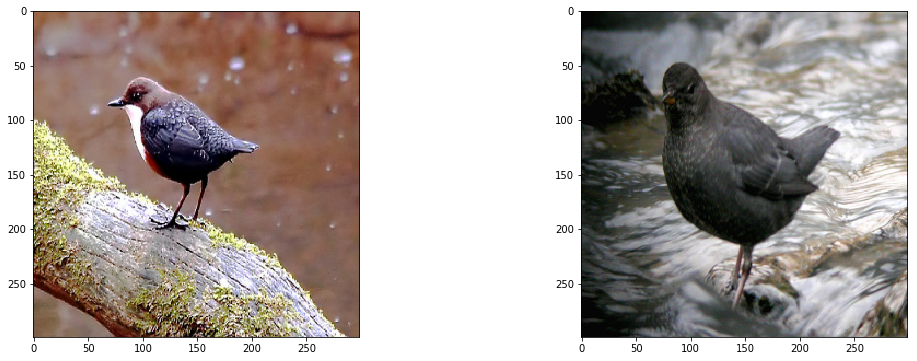

In [34]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('images/ouzel1.jpg', target_size=(299, 299))
img2 = utils.load_img('images/ouzel2.jpg', target_size=(299, 299))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

Time for saliency visualization.

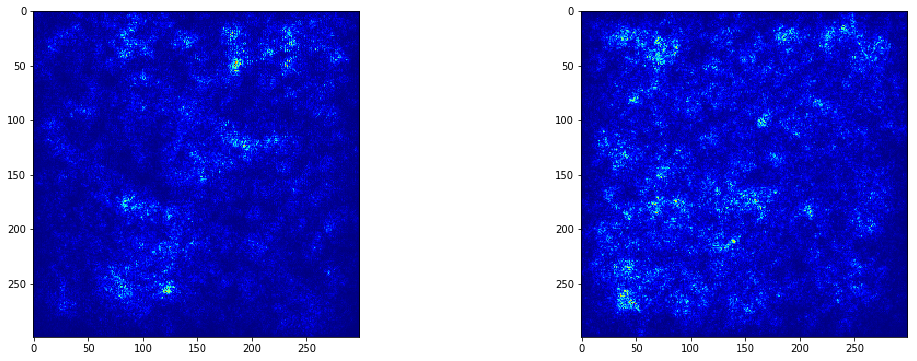

In [35]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_saliency(model, layer_idx, filter_indices=20, seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')

Not that great. Very noisy. Lets try guided and rectified saliency.

To use guided saliency, we need to set `backprop_modifier='guided'`. For rectified saliency or deconv saliency, use `backprop_modifier='relu'`.

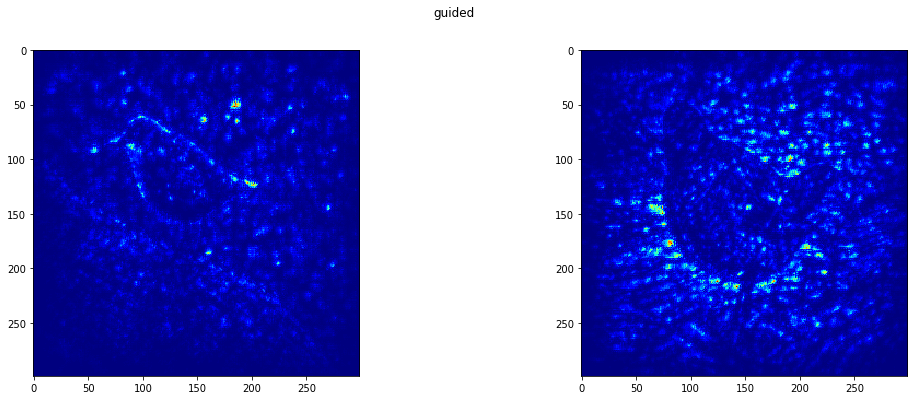

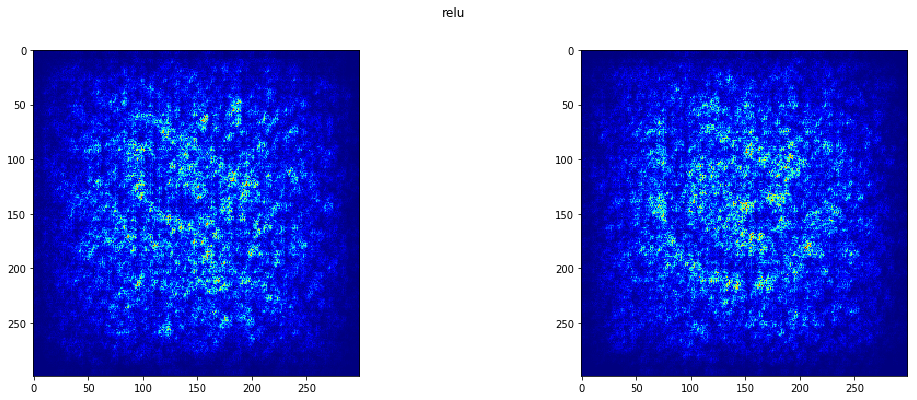

In [36]:
for modifier in ['guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_saliency(model, layer_idx, filter_indices=20, 
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.    
        ax[i].imshow(grads, cmap='jet')

guided saliency is definitely better. I am not sure whats going on with rectified saliency.

## grad-CAM - vanilla, guided, rectified

These should contain more detail since they use `Conv` or `Pooling` features that contain more spatial detail which is lost in `Dense` layers. The only additional detail compared to saliency is the `penultimate_layer_idx`. This specifies the pre-layer whose gradients should be used. See this paper for technical details: https://arxiv.org/pdf/1610.02391v1.pdf

By default, if `penultimate_layer_idx` is not defined, it searches for the nearest pre layer. For our architecture, that would be the `block5_pool` layer after all the `Conv` layers. Here is the model summary for reference.

In [37]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_287 (Conv2D)             (None, 149, 149, 32) 864         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_287 (BatchN (None, 149, 149, 32) 96          conv2d_287[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 149, 149, 32) 0           batch_normalization_287[0][0]    
__________________________________________________________________________________________________
conv2d_288

conv2d_347 (Conv2D)             (None, 17, 17, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
conv2d_350 (Conv2D)             (None, 17, 17, 192)  258048      activation_345[0][0]             
__________________________________________________________________________________________________
conv2d_355 (Conv2D)             (None, 17, 17, 192)  258048      activation_350[0][0]             
__________________________________________________________________________________________________
conv2d_356 (Conv2D)             (None, 17, 17, 192)  147456      average_pooling2d_34[0][0]       
__________________________________________________________________________________________________
batch_normalization_347 (BatchN (None, 17, 17, 192)  576         conv2d_347[0][0]                 
__________________________________________________________________________________________________
batch_norm

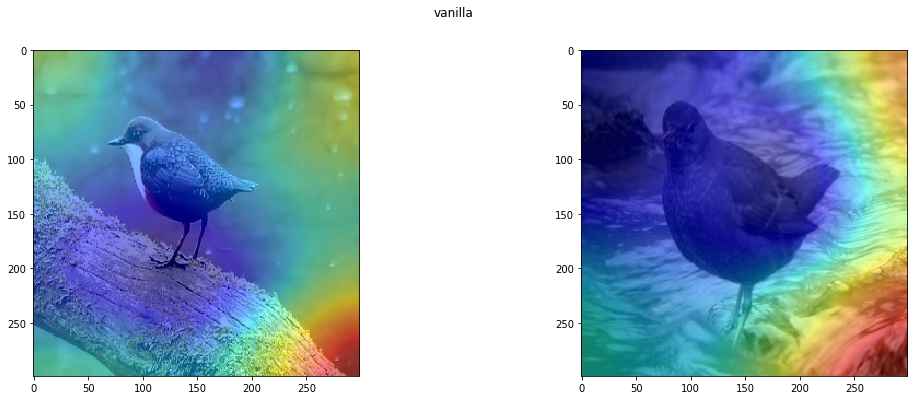

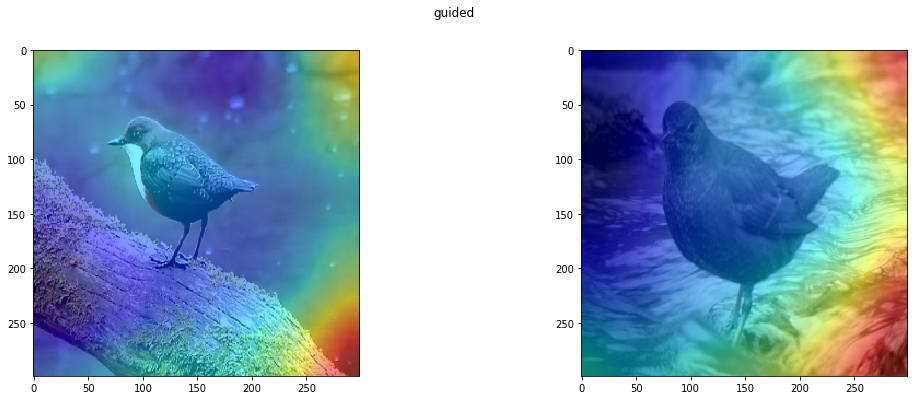

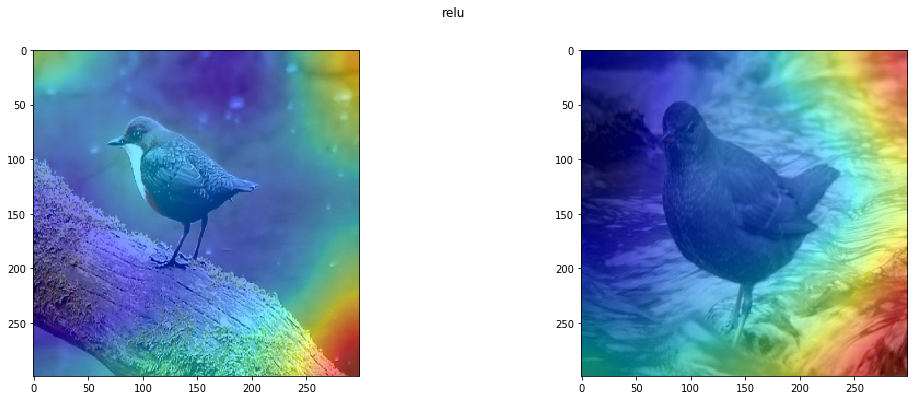

In [38]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(model, layer_idx, filter_indices=20, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))

guided grad-CAM wins again. It far less noisy than other options.